# Firefox engineering bug-to-nightly lead time trends

Has the time from a bug being filed until all changesets addressing that bug have been submitted to the mozilla-central source repository changed significantly from 2016 to 2018?

In [1]:
import pandas as pd
import seaborn as sns

sns.set_style("darkgrid")

We'll use a 3 month block, January to March in 2016, 2017, and 2018.  This should eliminate any large month-to-month effects.  The data should also be consistant because no major team event happens during these months.

In [2]:
files = ['data/nightly-{}{}.parq'.format(y, m)
         for y in (2016, 2017, 2018) 
         for m in ('01', '02', '03')]

In [3]:
df = pd.concat([pd.read_parquet(fn) for fn in files], ignore_index=True)
df.shape

(40092, 8)

Fix the timezone locale

In [4]:
df['bug_creation_time'] = df['bug_creation_time'].dt.tz_localize('UTC')
df['changeset_pushtime'] = df['changeset_pushtime'].dt.tz_localize('UTC')

For our "time from changeset inception until changeset fix" calculation we will take the time from when a changeset was created until the time that changeset was availalbe for download as a nightly build.

In [5]:
df['duration'] = df['changeset_pushtime'] - df['bug_creation_time']
df['duration'].min()

Timedelta('-640 days +07:59:25')

Clean up bad negative timedeltas.

In [6]:
# Scrub negative bug creation times
df = df.drop(df[df['duration'].dt.days < 0].index)
df['duration'].min()

Timedelta('0 days 00:02:45')

In [7]:
grouped = df.groupby(df['changeset_pushtime'].dt.year)

In [10]:
grouped['duration'].describe()

,count,mean,std,min,25%,50%,75%,max
changeset_pushtime,,,,,,,,
2016,11793,268 days 13:06:23.801492,976 days 01:41:17.925739,0 days 00:07:46,3 days 16:53:09,13 days 20:23:31,77 days 05:48:09,6162 days 02:12:57
2017,16166,1320 days 07:53:05.728256,2470 days 13:34:54.749854,0 days 00:02:45,5 days 11:39:00,26 days 17:33:08.500000,405 days 13:00:12.750000,7067 days 10:59:06
2018,12132,374 days 00:24:31.408341,1306 days 18:01:18.867007,0 days 00:03:08,2 days 20:01:27.250000,12 days 14:01:22.500000,66 days 00:24:00,6694 days 12:12:09


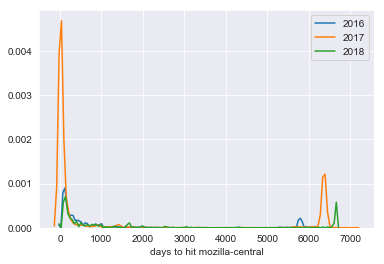

In [11]:
for year, data in grouped['duration']:
    ax = sns.kdeplot(data.dt.days, label=year)
    ax.set(xlabel="days to hit mozilla-central")

## Fixes landing within 90 days of bug filing

Focus on changesets that took less than 90 days from bug filing until the time that the fix landed in mozilla-central.  That range describes the majority of code landings.

In [13]:
last90 = df[df['duration'].dt.days <= 90]

In [17]:
grouped = last90['duration'].groupby(last90['changeset_pushtime'].dt.year)
grouped.describe()

,count,mean,std,min,25%,50%,75%,max
changeset_pushtime,,,,,,,,
2016,9089,16 days 19:48:38.627241,20 days 16:48:28.148811,0 days 00:07:46,2 days 14:53:00,7 days 15:04:30,21 days 21:45:40,90 days 19:55:27
2017,10539,18 days 02:05:49.521871,21 days 14:43:28.441428,0 days 00:02:45,2 days 18:16:05,8 days 01:21:53,25 days 02:02:30,90 days 22:01:31
2018,9542,16 days 05:00:04.746908,20 days 18:46:34.732766,0 days 00:03:08,1 days 23:49:50.250000,6 days 11:17:26,22 days 07:42:30,90 days 21:52:38


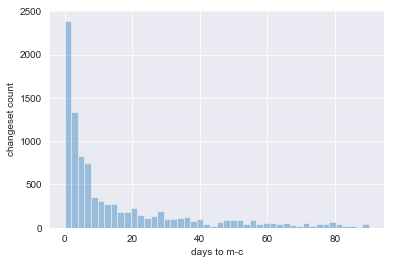

In [22]:
ax = sns.distplot(grouped.get_group(2018).dt.days, kde=False)
ax.set(xlabel="days to m-c", ylabel="changeset count");

Let's see how this looks fit to a KDE plot.

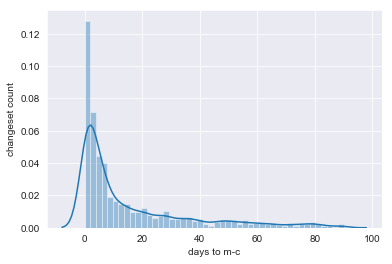

In [23]:
ax = sns.distplot(grouped.get_group(2018).dt.days)
ax.set(xlabel="days to m-c", ylabel="changeset count");

Now we can compare the result with other years.

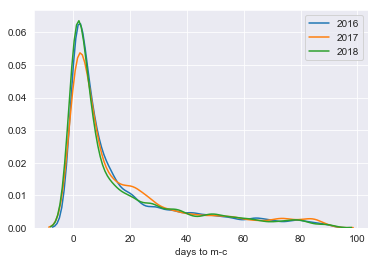

In [24]:
for year, data in grouped:
    ax = sns.kdeplot(data.dt.days, label=year)
    ax.set(xlabel="days to m-c")

A cumulative distribution shows us the difference in bug fix times between years as "percent of changeset-duration-to-mozilla-central durations that fall below a given percent of the total".

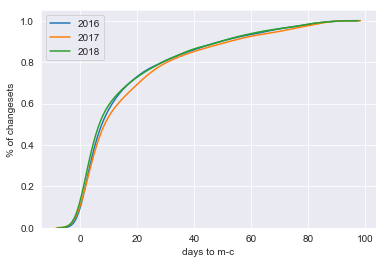

In [26]:
for year, data in grouped:
    ax = sns.kdeplot(data.dt.days, label=year, cumulative=True)
    ax.set(xlabel="days to m-c", ylabel="% of changesets")